In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


import sys
sys.path.append('../../..')
from batchflow.opensets import Imagenette160
from batchflow import Pipeline, B, V, C, W

from batchflow.models.torch import ResNet34, ResBlock
from batchflow.models.torch.layers import ConvBlock

from batchflow.models.metrics import ClassificationMetrics
from batchflow.research import Research, Option, Results, KV, RP, REU, RI
from batchflow.utils import plot_results_by_config, show_research, print_results

In [2]:
# Global constants
NUM_ITERS = 50000                               # number of iterations to train each model for
N_REPS = 4                                      # number of times to repeat each model train
RESEARCH_NAME = 'research'                      # name of Research object
DEVICES = [3, 4, 5, 6, 7]                       # devices to use
WORKERS = len(DEVICES)                          # number of simultaneously trained models
TEST_FREQUENCY = 200

dataset = Imagenette160()                       # dataset to train models on

In [3]:
domain = (Option('body', [KV({}, 'ResBlock'),
                          # apply chosen self-attention to each block
                          KV({'encoder/blocks' : {'attention_mode': 'se'}},
                             'block_SE_default'),
                          KV({'encoder/blocks' : {'attention_mode': 'scse'}},
                             'block_SCSE_default'),
                          KV({'encoder/blocks' : {'attention_mode': 'bam'}},
                             'block_BAM_default'),
                          KV({'encoder/blocks' : {'attention_mode': 'cbam'}},
                             'block_CBAM_default'),
                          KV({'encoder/blocks' : {'attention_mode': 'se', 'self_attention/ratio': 8}},
                             'block_SE_8'),
                          # apply chosen self-attention once per stage
                          KV({'encoder/order': ['skip', 'block', 'd'],
                              'encoder/downsample': {'layout': 'S', 'attention_mode': 'se'}},
                             'stage_SE_default'),
                          KV({'encoder/order': ['skip', 'block', 'd'],
                              'encoder/downsample': {'layout': 'S', 'attention_mode': 'scse'}},
                             'stage_SCSE_default'),
                          KV({'encoder/order': ['skip', 'block', 'd'],
                              'encoder/downsample': {'layout': 'S', 'attention_mode': 'bam'}},
                             'stage_BAM_default'),
                          KV({'encoder/order': ['skip', 'block', 'd'],
                              'encoder/downsample': {'layout': 'S', 'attention_mode': 'cbam'}},
                             'stage_CBAM_default'),
                         ]))

In [4]:
config = {
    'inputs/labels/classes': 10,
    'body': C('body'),
    'head/layout': 'Vf',
    'head/units': 10,
    "decay": dict(name='exp', gamma=0.1),
    "n_iters": 7500,
    'device': C('device'),
}

In [5]:
train_root = (dataset.train.p      
                  .crop(shape=(160, 160), origin='center')
                  .to_array(channels='first', dtype=np.float32)
                  .multiply(multiplier=1/255)
                  .run_later(64, n_epochs=None, drop_last=True,
                             shuffle=True, prefetch=5)
                   )

train_pipeline = (Pipeline()
                  .init_variable('loss')
                  .init_model('dynamic', ResNet34, 'my_model', config=config) 
                  .train_model('my_model', B('images'), B('labels'), 
                               fetches='loss', save_to=V('loss'))
                 )

In [6]:
def acc(iteration, import_from):
    pipeline = (dataset.test.p
                 .import_model('my_model', import_from)
                 .init_variable('true', [])
                 .update(V('true', mode='a'), B.labels) 
                 .init_variable('predictions', [])
                 .crop(shape=(160, 160), origin='center')
                 .to_array(channels='first', dtype=np.float32)
                 .multiply(multiplier=1/255)
                 .predict_model('my_model', B('images'), fetches='predictions',
                                save_to=V('predictions', mode='a'))
                 )
    pipeline.run(128, n_epochs=1, drop_last=False, shuffle=True)
    pred = np.concatenate(pipeline.v('predictions'))
    true = np.concatenate(pipeline.v('true'))
    accuracy = ClassificationMetrics(true, pred, fmt='logits',
                                     num_classes=10, axis=1).accuracy()
    return accuracy

In [7]:
research = (Research()
            .init_domain(domain, n_reps=N_REPS)
            .add_pipeline(root=train_root, branch=train_pipeline, variables='loss',
                          name='train_ppl', logging=True)
            .add_callable(acc, returns='acc_vall', name='acc_fn', execute=TEST_FREQUENCY,
                          iteration=RI(), import_from=RP('train_ppl')))

In [ ]:
!rm -rf research

research.run(NUM_ITERS, name=RESEARCH_NAME,
             devices=DEVICES, workers=WORKERS,
             bar=True)

Research research is starting...


Domain updated: 0:  12%|█▏        | 243804/2000000.0 [6:10:39<44:29:55, 10.96it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Domain updated: 0:  15%|█▍        | 294387/2000000.0 [7:26:48<43:08:41, 10.98it/s]

In [ ]:
%%time
results = Results(path=RESEARCH_NAME, concat_config=True)
# results = research.load_results(concat_config=True)

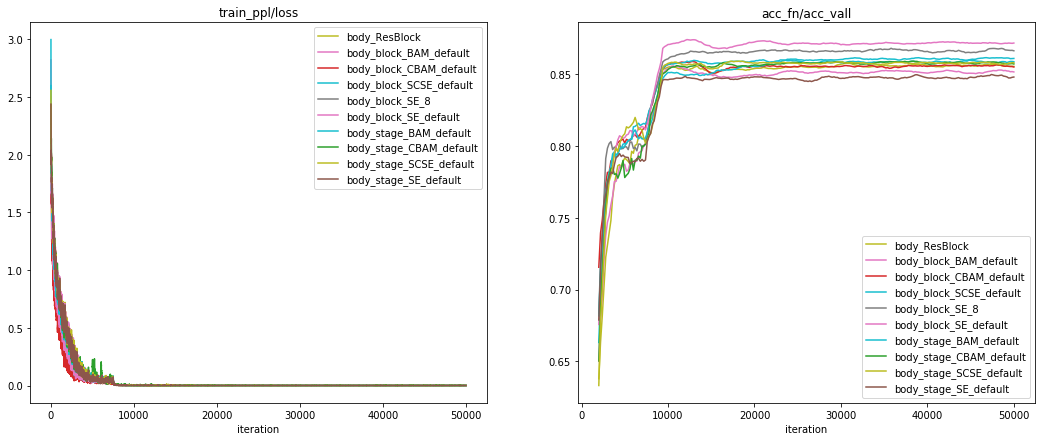

In [14]:
show_research(results.df, layout=['train_ppl/loss', 'acc_fn/acc_vall'], average_repetitions=True, 
              color=list(mcolors.TABLEAU_COLORS.keys()), log_scale=False, rolling_window=10)

In [12]:
print_results(results.df, 'acc_fn/acc_vall', False, ascending=True, n_last=100)

,acc_fn_3,acc_fn_2,acc_fn_1,acc_fn_0,acc_fn_mean,acc_fn_std
body_ResBlock,0.852156,0.835729,0.864476,0.868583,0.855236,0.012782
body_block_BAM_default,0.856263,0.837782,0.858316,0.839836,0.848049,0.009297
body_block_CBAM_default,0.860370,0.852156,0.854209,0.850103,0.854209,0.003842
body_block_SCSE_default,0.854209,0.864476,0.864476,0.870637,0.863450,0.005898
body_block_SE_8,0.862423,0.864476,0.868583,0.862423,0.864476,0.002515
body_block_SE_default,0.878850,0.866530,0.868583,0.876797,0.872690,0.005235
body_stage_BAM_default,0.868583,0.854209,0.868583,0.845996,0.859343,0.009686
body_stage_CBAM_default,0.858316,0.860370,0.845996,0.856263,0.855236,0.005529
body_stage_SCSE_default,0.850103,0.858316,0.854209,0.858316,0.855236,0.003405
body_stage_SE_default,0.843943,0.841889,0.845996,0.864476,0.849076,0.009009


In [13]:
1+0

1